In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image

PIC_DIR = f"/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"

from tqdm import tqdm
IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128

#Images.open.crop(left,top,right,bottom)
#this is used to crop the images
crop_react = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []

for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_react)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))
    
images = np.array(images) / 255
print(images.shape)


100%|██████████| 10000/10000 [01:18<00:00, 128.04it/s]


(10000, 128, 128, 3)


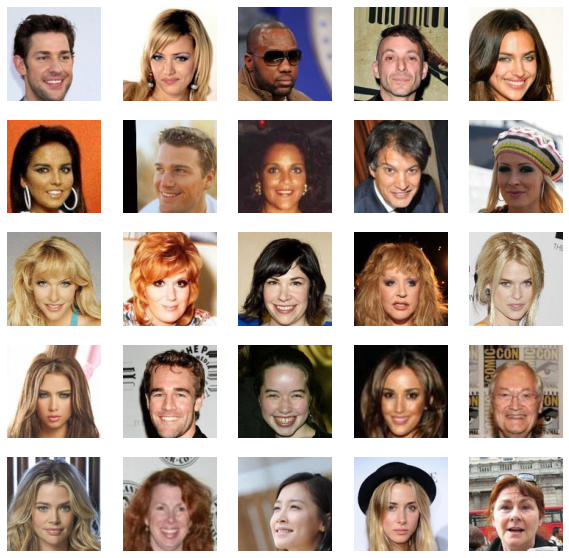

In [2]:
from matplotlib import pyplot as plt

plt.figure(1, figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [3]:
# ! pip install keras
# ! pip install tensorflow

# ! pip install --upgrade tensorflow
#! pip install --upgrade tensorflow-gpu
#! nvidia-smi
#torch.cuda.get_device_name(0)

In [4]:
#import tensorflow as tf
import tensorflow
from tensorflow import keras 
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense,Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop


LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator




2021-09-28 14:44:24.932829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [5]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [6]:
generator = create_generator()
discriminator = create_discriminator()

discriminator.trainable = False

gan_input = Input(shape = (LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))

gan = Model(gan_input,gan_output)

optimizer = RMSprop(learning_rate = 0.0001, clipvalue = 1.0, decay = 1e-8)

gan.compile(optimizer = optimizer, loss = 'binary_crossentropy')

2021-09-28 14:44:29.814925: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-28 14:44:29.818092: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-28 14:44:29.855094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-28 14:44:29.855827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-28 14:44:29.855887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-28 14:44:29.882267: I tensorflow/stream_executor/platform/def

2021-09-28 14:44:32.250365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-28 14:44:32.260475: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz
2021-09-28 14:44:32.436135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-28 14:44:33.187718: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-28 14:44:33.221759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


50/20000: d_loss: 0.6420,  a_loss: 0.6776.  (0.8 sec)
100/20000: d_loss: 0.7793,  a_loss: 0.7384.  (0.8 sec)
150/20000: d_loss: 0.5259,  a_loss: 0.9763.  (0.9 sec)
200/20000: d_loss: 0.5740,  a_loss: 1.7732.  (0.8 sec)
250/20000: d_loss: 0.7980,  a_loss: 0.9278.  (0.8 sec)
300/20000: d_loss: 0.6294,  a_loss: 0.7665.  (0.8 sec)
350/20000: d_loss: 0.6294,  a_loss: 0.9684.  (0.8 sec)
400/20000: d_loss: 0.6457,  a_loss: 0.8135.  (0.8 sec)
450/20000: d_loss: 0.6480,  a_loss: 0.8807.  (0.8 sec)
500/20000: d_loss: 0.6851,  a_loss: 1.0391.  (0.8 sec)
550/20000: d_loss: 0.6248,  a_loss: 0.7811.  (0.8 sec)
600/20000: d_loss: 0.6338,  a_loss: 0.8794.  (0.8 sec)
650/20000: d_loss: 0.6767,  a_loss: 0.8631.  (0.8 sec)
700/20000: d_loss: 0.6446,  a_loss: 1.2614.  (0.8 sec)
750/20000: d_loss: 0.7426,  a_loss: 1.0858.  (0.8 sec)
800/20000: d_loss: 0.7556,  a_loss: 1.3035.  (0.8 sec)
850/20000: d_loss: 0.6565,  a_loss: 0.7861.  (0.8 sec)
900/20000: d_loss: 0.6919,  a_loss: 0.7972.  (0.8 sec)
950/20000: 

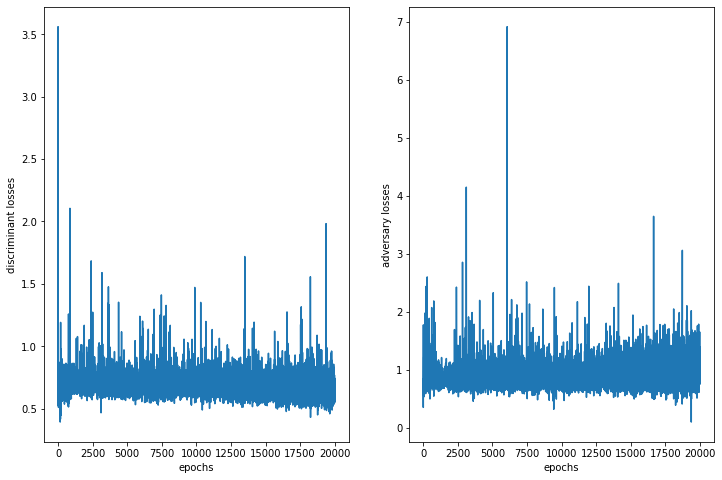

In [7]:
import time
iters = 20000
batch_size = 8

RES_DIR = f"./res2"
FILE_PATH = "%sgenerated%d.png"

if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
    
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size = (CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0

for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('./gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

        
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()
    